# Classification Metric C-index from Scratch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###### Load Data

In [2]:
def generate_data(n=200):
    df = pd.DataFrame(
        columns=['Age', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol']
    )
    df.loc[:, 'Age'] = np.exp(np.log(60) + (1 / 7) * np.random.normal(size=n))
    df.loc[:, ['Systolic_BP', 'Diastolic_BP', 'Cholesterol']] = np.exp(
        np.random.multivariate_normal(
            mean=[np.log(100), np.log(90), np.log(100)],
            cov=(1 / 45) * np.array([
                [0.5, 0.2, 0.2],
                [0.2, 0.5, 0.2],
                [0.2, 0.2, 0.5]]),
            size=n))
    return df

def f(x):
    p = 0.4 * (np.log(x[0]) - np.log(60)) + 0.33 * (
            np.log(x[1]) - np.log(100)) + 0.3 * (
                np.log(x[3]) - np.log(100)) - 2.0 * (
                np.log(x[0]) - np.log(60)) * (
                np.log(x[3]) - np.log(100)) + 0.05 * np.random.logistic()
    if p > 0.0:
        return 1.0
    else:
        return 0.0
    
def load_data(n=200):
    np.random.seed(0)
    df = generate_data(n)
    for i in range(len(df)):
        df.loc[i, 'y'] = f(df.loc[i, :])
        X = df.drop('y', axis=1)
        y = df.y
    return X, y

In [3]:
X, y = load_data(6000)

In [4]:
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


In [5]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: y, dtype: float64

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.75)

Plot the histograms of each column of `X_train` below: 

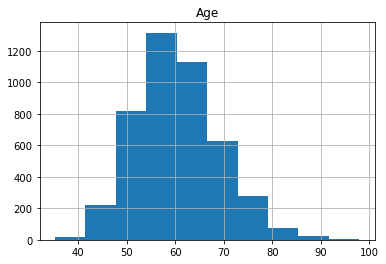

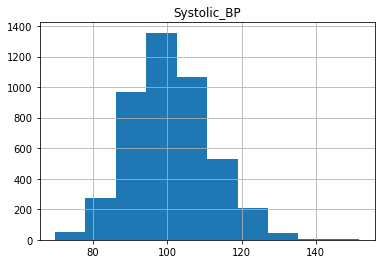

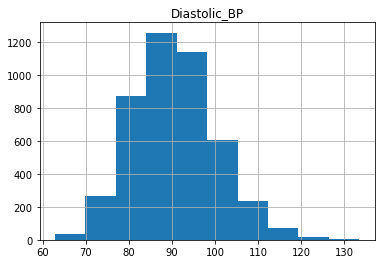

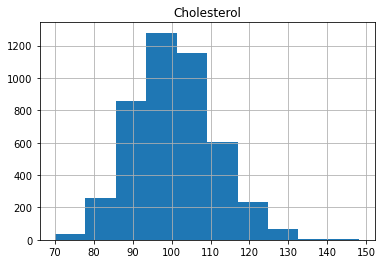

In [8]:
for col in X.columns:
    X_train_raw.loc[:, col].hist()
    plt.title(col)
    plt.show()

As we can see, the distributions have a generally bell shaped distribution, but with slight rightward skew.

Many statistical models assume that the data is normally distributed, forming a symmetric Gaussian bell shape (with no skew) more like the example below.

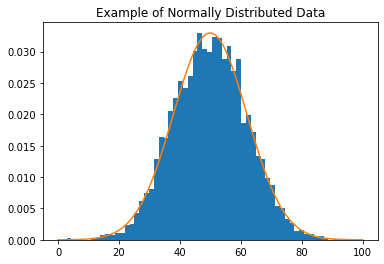

In [9]:
from scipy.stats import norm
data = np.random.normal(50,12, 5000)
fitting_params = norm.fit(data)
norm_dist_fitted = norm(*fitting_params)
t = np.linspace(0,100, 100)
plt.hist(data, bins=60, density=True)
plt.plot(t, norm_dist_fitted.pdf(t))
plt.title('Example of Normally Distributed Data')
plt.show()

We can transform our data to be closer to a normal distribution by removing the skew. One way to remove the skew is by applying the log function to the data.

Let's plot the log of the feature variables to see that it produces the desired effect.

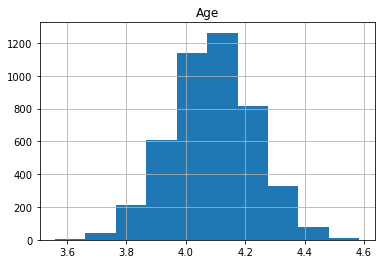

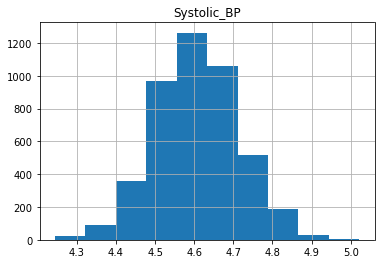

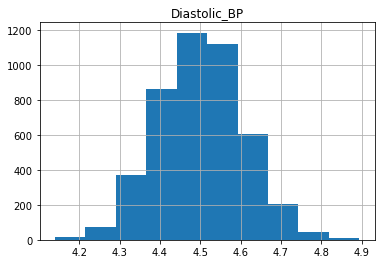

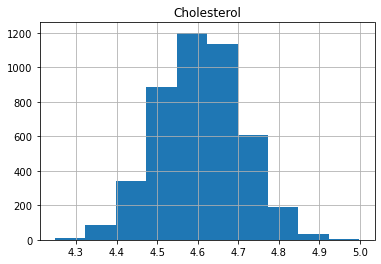

In [10]:
for col in X_train_raw.columns:
    np.log(X_train_raw.loc[:, col]).hist()
    plt.title(col)
    plt.show()

We can see that the data is more symmetric after taking the log.

###### Mean-Normalize the Data

Let's now transform our data so that the distributions are closer to standard normal distributions.

In [11]:
def make_standard_normal(df_train, df_test):
    """
    In order to make the data closer to a normal distribution, take log
    transforms to reduce the skew.
    Then standardize the distribution with a mean of zero and standard deviation of 1. 
  
    Args:
      df_train (dataframe): unnormalized training data.
      df_test (dataframe): unnormalized test data.
  
    Returns:
      df_train_normalized (dateframe): normalized training data.
      df_test_normalized (dataframe): normalized test data.
    """
    
    # Remove skew by applying the log function to the train set, and to the test set
    df_train_unskewed = np.log(df_train)
    df_test_unskewed = np.log(df_test)
    
    #calculate the mean and standard deviation of the training set
    mean = df_train_unskewed.mean(axis=0)
    stdev = df_train_unskewed.std(axis=0)
    
    # standardize the training set
    df_train_standardized = (df_train_unskewed - mean) / stdev
    
    # standardize the test set (see instructions and hints above)
    df_test_standardized = (df_test_unskewed - mean) / stdev
    
    return df_train_standardized, df_test_standardized

#### Transform training and test data 
Use the function that you just implemented to make the data distribution closer to a standard normal distribution.

In [12]:
X_train, X_test = make_standard_normal(X_train_raw, X_test_raw)

After transforming the training and test sets, we'll expect the training set to be centered at zero with a standard deviation of $1$.

We will avoid observing the test set during model training in order to avoid biasing the model training process, but let's have a look at the distributions of the transformed training data.

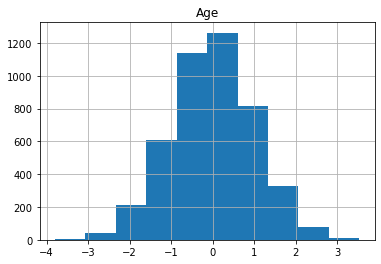

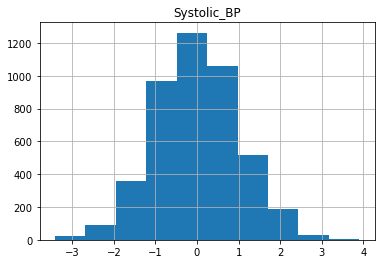

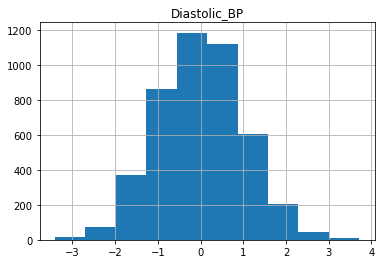

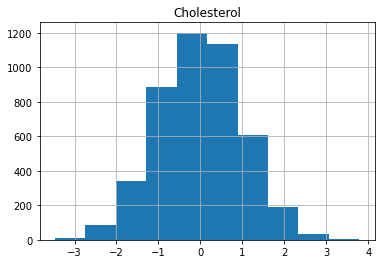

In [13]:
for col in X_train.columns:
    X_train[col].hist()
    plt.title(col)
    plt.show()

###### Build the Model

Now we are ready to build the risk model by training logistic regression with our data.



In [14]:
def lr_model(X_train, y_train):
    
    # import the LogisticRegression class
    from sklearn.linear_model import LogisticRegression
    
    # create the model object
    model = LogisticRegression()
    
    # fit the model to the training data
    model.fit(X_train, y_train)
    
    #return the fitted model
    return model

In [15]:
model_X = lr_model(X_train, y_train)

###### Evaluate the Model Using the C-index

Now that we have a model, we need to evaluate it. We'll do this using the c-index. 
* The c-index measures the discriminatory power of a risk score. 
* Intuitively, a higher c-index indicates that the model's prediction is in agreement with the actual outcomes of a pair of patients.
* The formula for the c-index is

$$ \mbox{cindex} = \frac{\mbox{concordant} + 0.5 \times \mbox{ties}}{\mbox{permissible}} $$

* A permissible pair is a pair of patients who have different outcomes.
* A concordant pair is a permissible pair in which the patient with the higher risk score also has the worse outcome.
* A tie is a permissible pair where the patients have the same risk score.



* Implement the `cindex` function to compute c-index.
* `y_true` is the array of actual patient outcomes, 0 if the patient does not eventually get the disease, and 1 if the patient eventually gets the disease.
* `scores` is the risk score of each patient.  These provide relative measures of risk, so they can be any real numbers. By convention, they are always non-negative.
* Here is an example of input data and how to interpret it:
```Python
y_true = [0,1]
scores = [0.45, 1.25]
```
    * There are two patients. Index 0 of each array is associated with patient 0.  Index 1 is associated with patient 1.
    * Patient 0 does not have the disease in the future (`y_true` is 0), and based on past information, has a risk score of 0.45.
    * Patient 1 has the disease at some point in the future (`y_true` is 1), and based on past information, has a risk score of 1.25.

In [16]:
def cindex(y_true, scores):
    '''

    Input:
    y_true (np.array): a 1-D array of true binary outcomes (values of zero or one)
        0: patient does not get the disease
        1: patient does get the disease
    scores (np.array): a 1-D array of corresponding risk scores output by the model

    Output:
    c_index (float): (concordant pairs + 0.5*ties) / number of permissible pairs
    '''
    n = len(y_true)
    assert len(scores) == n

    concordant = 0
    permissible = 0
    ties = 0
    
    # use two nested for loops to go through all unique pairs of patients
    for i in range(n):
        for j in range(i+1, n):
            
            # Check if the pair is permissible (the patient outcomes are different)
            if y_true[i] != y_true[j]:
                # Count the pair if it's permissible
                permissible += 1

                # For permissible pairs, check if they are concordant or are ties
                # check for ties in the score
                if scores[i] == scores[j]:
                    # count the tie
                    ties +=1
                    # if it's a tie, we don't need to check patient outcomes, continue to the top of the for loop.
                    continue

                # case 1: patient i doesn't get the disease, patient j does
                if y_true[i] == 0 and y_true[j] == 1:
                    # Check if patient i has a lower score than patient j
                    if scores[i] < scores[j]:
                        # count the concordant pair
                        concordant += 1
                    # Otherwise if patient i has a higher risk score, it's not a concordant pair.
                    # We already checked for ties earlier

                # case 2: patient i gets the disease, patient j does not
                if y_true[i] == 1 and y_true[j] == 0:
                    # Check if patient i has a higher risk score than patient j
                    if scores[i] > scores[j]:
                        #count the concordant pair
                        concordant +=1
                    # Otherwise if patient i has a lower risk score, it's not a concordant pair.
                    # We already checked for ties earlier

    # calculate the c-index using the count of permissible pairs, concordant pairs, and tied pairs.
    c_index = (concordant + 0.5* ties)/permissible
    
    return c_index

You can use the following test cases to make sure your implementation is correct.

In [17]:
# test
y_true = np.array([1.0, 0.0, 0.0, 1.0])

# Case 1
scores = np.array([0, 1, 1, 0])
print('Case 1 Output: {}'.format(cindex(y_true, scores)))

# Case 2
scores = np.array([1, 0, 0, 1])
print('Case 2 Output: {}'.format(cindex(y_true, scores)))

# Case 3
scores = np.array([0.5, 0.5, 0.0, 1.0])
print('Case 3 Output: {}'.format(cindex(y_true, scores)))
cindex(y_true, scores)

Case 1 Output: 0.0
Case 2 Output: 1.0
Case 3 Output: 0.875


0.875

#### Expected Output

```CPP
Case 1 Output: 0.0
Case 2 Output: 1.0
Case 3 Output: 0.875
```

###### Evaluate the Model on the Test Set

Now, you can evaluate your trained model on the test set.  

To get the predicted probabilities, we use the `predict_proba` method. This method will return the result from the model *before* it is converted to a binary 0 or 1. For each input case, it returns an array of two values which represent the probabilities for both the negative case (patient does not get the disease) and positive case (patient the gets the disease). 

In [18]:
scores = model_X.predict_proba(X_test)[:, 1]
c_index_X_test = cindex(y_test.values, scores)
print(f"c-index on test set is {c_index_X_test:.4f}")

c-index on test set is 0.8336


Let's plot the coefficients to see which variables (patient features) are having the most effect. You can access the model coefficients by using `model.coef_`

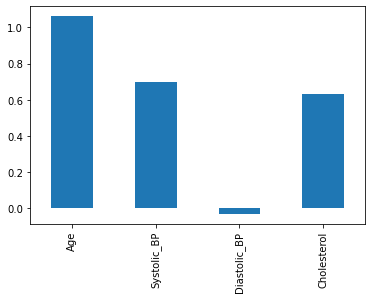

In [19]:
coeffs = pd.DataFrame(data = model_X.coef_, columns = X_train.columns)
coeffs.T.plot.bar(legend=None);